In [1]:
import razor
import razor.flow as rf
from razor import api
from razor.flow.spark import SparkBlock, SparkExecutor

import os
from datetime import datetime, timedelta
from pyspark.sql import SparkSession, functions
from pyspark.sql.dataframe import DataFrame
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pyspark.sql.types import IntegerType, DateType, ArrayType, StringType, FloatType, TimestampType

from pyspark.sql.functions import pandas_udf, PandasUDFType,collect_set

In [2]:
def project_space_path(path):
    ps = api.datasources('Project Space')
    return os.path.join(ps.abspath(), path)

In [3]:
def get_customer_static_info(input_df):
    customer_static = input_df.select(["customer_name", "card_number", "card_type"])
    return customer_static

def get_merchant_static_info(input_df):
    merchant_static_temp = input_df.select(["merchant_id", "product_type"])
    merchant_static_data = input_df.select(["merchant_id", "merchant_city", "merchant_state"])
    merchant_static_temp = merchant_static_temp.groupBy("merchant_id").agg(collect_set("product_type").alias("list_of_product"))
    merchant_static = merchant_static_data.join(merchant_static_temp, on='merchant_id', how='left')
    return merchant_static

In [4]:
def get_customer_ts(df):
    df = df.withColumn("time", df["time"].cast(TimestampType()))
    df = df.withColumn("amount", df["amount"].cast(IntegerType()))
    df = df.select(["transaction_id", "time", "customer_name", "card_number", "amount"])
    
    df1 = df.withColumn("tuplecol", functions.struct([functions.col("transaction_id") , functions.col("time") , functions.col("amount")]))
    
    df2 = df1.groupby("card_number").agg(functions.collect_list("tuplecol"))
    final_customer_df = df.join(df2, on='card_number', how = 'inner')
    final_customer_df = final_customer_df.withColumnRenamed('collect_list(tuplecol)', 'tuplecol')
    
    time_udf = functions.udf(get_customer_timeseries_feature, ArrayType(ArrayType(IntegerType())))
    final_customer_df=final_customer_df.withColumn("results",time_udf(functions.col("tuplecol"),functions.col("time")))
    
    final_customer_df = final_customer_df.select(["results", "transaction_id"])
    df = df.select(["transaction_id", "time", "customer_name", "card_number"])
    final_customer_df = df.join(final_customer_df, on='transaction_id', how = 'inner')
    
    feature_vector_udf = functions.udf(get_feature_vector, IntegerType())
    avg_feature_vector_udf = functions.udf(get_avg_feature_vector, FloatType())
    
    feature_type = ['sum','count','max', 'avg']
    timespan = ['one_hour','six_hours','twelve_hours', 'twenty_four_hours', 'three_days', 'one_week', 'two_week', 'one_month']
    for i in range(0,len(timespan)):
        for j in range(0,len(feature_type)):
            if feature_type[j]=='avg':
                final_customer_df = final_customer_df.withColumn("last_" + timespan[i] + "_total_customer_transaction_" + feature_type[j],avg_feature_vector_udf(functions.col("results"),functions.lit(i)))
            else:
                final_customer_df = final_customer_df.withColumn("last_" + timespan[i] + "_total_customer_transaction_" + feature_type[j],feature_vector_udf(functions.col("results"),functions.lit(j),functions.lit(i)))
    
    final_customer_df = final_customer_df.drop('results')
    
    return final_customer_df


def get_merchant_ts(df):
    df = df.withColumn("time", df["time"].cast(TimestampType()))
    df = df.withColumn("amount", df["amount"].cast(IntegerType()))
    # df = df.select(["transaction_id", "time", "customer_name", "card_number", "amount"])
    df = df.select(['transaction_id',"time", 'merchant_id', 'merchant_city', 'merchant_state',"amount"])
    
    df1 = df.withColumn("tuplecol", functions.struct([functions.col("transaction_id") , functions.col("time") , functions.col("amount")]))
    
    df2 = df1.groupby("merchant_id").agg(functions.collect_list("tuplecol"))
    final_customer_df = df.join(df2, on='merchant_id', how = 'inner')
    final_customer_df = final_customer_df.withColumnRenamed('collect_list(tuplecol)', 'tuplecol')
    
    time_udf = functions.udf(get_merchant_timeseries_feature, ArrayType(ArrayType(IntegerType())))
    final_customer_df=final_customer_df.withColumn("results",time_udf(functions.col("tuplecol"),functions.col("time"),functions.col("transaction_id")))
    
    final_customer_df = final_customer_df.select(["results", "transaction_id"])
    df = df.select(['transaction_id', 'merchant_id', 'merchant_city', 'merchant_state'])
    final_customer_df = df.join(final_customer_df, on='transaction_id', how = 'inner')
    
    feature_vector_udf = functions.udf(get_feature_vector, IntegerType())
    avg_feature_vector_udf = functions.udf(get_avg_feature_vector, FloatType())
    
    feature_type = ['sum','count','max', 'avg']
    timespan = ['one_hour','six_hour','twelve_hour', 'twenty_four_hour', 'three_days']
    for i in range(0,5):
        for j in range(0,4):
            if feature_type[j]=='avg':
                final_customer_df = final_customer_df.withColumn("last_" + timespan[i] + "_total_merchant_transaction_" + feature_type[j],avg_feature_vector_udf(functions.col("results"),functions.lit(i)))
            else:
                final_customer_df = final_customer_df.withColumn("last_" + timespan[i] + "_total_merchant_transaction_" + feature_type[j],feature_vector_udf(functions.col("results"),functions.lit(j),functions.lit(i)))

    final_customer_df = final_customer_df.drop('results')
    
    return final_customer_df


def get_customer_timeseries_feature(history,current_time):
    last_hour_amount_history = [0,]
    last_6hour_amount_history = [0,]
    last_12hour_amount_history = [0,]
    last_24hour_amount_history = [0,]
    last_3day_amount_history = [0,]
    last_1week_amount_history = [0,]
    last_2week_amount_history = [0,]
    last_1month_amount_history = [0,]
       
    history = sorted(history,key=lambda a: a[1])
    last_hour_time = current_time - timedelta(hours=1) 
    last_6hour_time = current_time - timedelta(hours=6)
    last_12hour_time = current_time - timedelta(hours=12)
    last_24hour_time = current_time - timedelta(hours=24)
    last_3day_time = current_time - timedelta(hours=72)
    last_1week_time = current_time - timedelta(days=7)
    last_2week_time = current_time - timedelta(days=14)
    last_1month_time = current_time - relativedelta(months=1)
    
    for item in history:
        if (item[1] < current_time) and (item[1] >= last_hour_time):
            last_hour_amount_history.append(item[2])
            
        if (item[1] < current_time) and (item[1] >= last_6hour_time):
            last_6hour_amount_history.append(item[2])
            
        if (item[1] < current_time) and (item[1] >= last_12hour_time):
            last_12hour_amount_history.append(item[2])
            
        if (item[1] < current_time) and (item[1] >= last_24hour_time):
            last_24hour_amount_history.append(item[2])
            
        if (item[1] < current_time) and (item[1] >= last_3day_time):
            last_3day_amount_history.append(item[2])
        
        if (item[1] < current_time) and (item[1] >= last_1week_time):
            last_1week_amount_history.append(item[2])
            
        if (item[1] < current_time) and (item[1] >= last_2week_time):
            last_2week_amount_history.append(item[2])
            
        if (item[1] < current_time) and (item[1] >= last_1month_time):
            last_1month_amount_history.append(item[2])
        
        # amount_feature = [sum, count, avg, max]
#     return [last_hour_amount_history,last_6hour_amount_history]
    last_hour_amount_feature = [sum(last_hour_amount_history),len(last_hour_amount_history)-1,max(last_hour_amount_history)]
    last_6hour_amount_feature = [sum(last_6hour_amount_history),len(last_6hour_amount_history)-1,max(last_6hour_amount_history)]
    last_12hour_amount_feature = [sum(last_12hour_amount_history),len(last_12hour_amount_history)-1,max(last_12hour_amount_history)]
    last_24hour_amount_feature = [sum(last_24hour_amount_history),len(last_24hour_amount_history)-1,max(last_24hour_amount_history)]
    last_3day_amount_feature = [sum(last_3day_amount_history),len(last_3day_amount_history)-1,max(last_3day_amount_history)]
    last_1week_amount_feature = [sum(last_1week_amount_history),len(last_1week_amount_history)-1,max(last_1week_amount_history)]
    last_2week_amount_feature = [sum(last_2week_amount_history),len(last_2week_amount_history)-1,max(last_2week_amount_history)]
    last_1month_amount_feature = [sum(last_1month_amount_history),len(last_1month_amount_history)-1,max(last_1month_amount_history)]




    return [last_hour_amount_feature,last_6hour_amount_feature,last_12hour_amount_feature,last_24hour_amount_feature,last_3day_amount_feature,last_1week_amount_feature,last_2week_amount_feature,last_1month_amount_feature]

def get_feature_vector(a,feature_type,timespan):
    return int(a[timespan][feature_type])

def get_avg_feature_vector(x,timespan):
    a= x[timespan][0]
    b= x[timespan][1]
    if b==0:
        return float(a/1)
    else:
        return float(a/b)


def get_merchant_timeseries_feature(history,current_time,current_transaction_id):
    last_hour_amount_history = [0,]
    last_6hour_amount_history = [0,]
    last_12hour_amount_history = [0,]
    last_24hour_amount_history = [0,]
    last_3day_amount_history = [0,]    
           
    history = sorted(history,key=lambda a: a[1])
    last_hour_time = current_time - timedelta(hours=1) 
    last_6hour_time = current_time - timedelta(hours=6)
    last_12hour_time = current_time - timedelta(hours=12)
    last_24hour_time = current_time - timedelta(hours=24)
    last_3day_time = current_time - timedelta(hours=72)
    
    for item in history:
        if item[0]!=current_transaction_id:
            if (item[1] <= current_time) and (item[1] >= last_hour_time):
                last_hour_amount_history.append(item[2])

            if (item[1] <= current_time) and (item[1] >= last_6hour_time):
                last_6hour_amount_history.append(item[2])

            if (item[1] <= current_time) and (item[1] >= last_12hour_time):
                last_12hour_amount_history.append(item[2])

            if (item[1] <= current_time) and (item[1] >= last_24hour_time):
                last_24hour_amount_history.append(item[2])

            if (item[1] <= current_time) and (item[1] >= last_3day_time):
                last_3day_amount_history.append(item[2])

        # amount_feature = [sum, count, avg, max]
#     return [last_hour_amount_history,last_6hour_amount_history]
    last_hour_amount_feature = [sum(last_hour_amount_history),len(last_hour_amount_history)-1,max(last_hour_amount_history)]
    last_6hour_amount_feature = [sum(last_6hour_amount_history),len(last_6hour_amount_history)-1,max(last_6hour_amount_history)]
    last_12hour_amount_feature = [sum(last_12hour_amount_history),len(last_12hour_amount_history)-1,max(last_12hour_amount_history)]
    last_24hour_amount_feature = [sum(last_24hour_amount_history),len(last_24hour_amount_history)-1,max(last_24hour_amount_history)]
    last_3day_amount_feature = [sum(last_3day_amount_history),len(last_3day_amount_history)-1,max(last_3day_amount_history)]

    return [last_hour_amount_feature,last_6hour_amount_feature,last_12hour_amount_feature,last_24hour_amount_feature,last_3day_amount_feature]


def get_product_type_ts(df):
    df = df.withColumn("time", df["time"].cast(TimestampType()))
    df = df.withColumn("amount", df["amount"].cast(IntegerType()))
    df = df.select(["transaction_id", "time", 'product_type', "customer_name", "card_number", "amount"])
    
    product_list = [item.product_type for item in df.select("product_type").distinct().collect()]
    product_list.append('Others')
    
    df1 = df.withColumn("tuplecol", functions.struct([functions.col("transaction_id") , functions.col("product_type") , functions.col("time") , functions.col("amount")]))
    
    df2 = df1.groupby("card_number").agg(functions.collect_list("tuplecol"))
    final_customer_df = df.join(df2, on='card_number', how = 'inner')
    final_customer_df = final_customer_df.withColumnRenamed('collect_list(tuplecol)', 'tuplecol')
    
    time_udf = functions.udf(get_product_type_timeseries_feature, ArrayType(ArrayType(FloatType())))
    final_customer_df=final_customer_df.withColumn("results",time_udf(functions.col("tuplecol"),functions.col("product_type"), functions.col("time")))
    
    final_customer_df = final_customer_df.select(["results", "transaction_id"])
    df = df.select(["transaction_id", "time", "customer_name", "card_number"])
    final_customer_df = df.join(final_customer_df, on='transaction_id', how = 'inner')
    
    feature_vector_udf = functions.udf(get_feature_vector_prod_type, FloatType())

    feature_type = ['count', 'avg_amount']
    for i in range(0,len(product_list)):
        for j in range(0,len(feature_type)):
            final_customer_df = final_customer_df.withColumn("last_2_months_" + product_list[i] + "_" + feature_type[j],feature_vector_udf(functions.col("results"),functions.lit(i),functions.lit(j)))

    final_customer_df = final_customer_df.drop('results')
    
    return final_customer_df


def get_transaction_city_ts(df):
    df = df.withColumn("time", df["time"].cast(TimestampType()))
    df = df.withColumn("amount", df["amount"].cast(IntegerType()))
    df = df.select(["transaction_id", "time", "customer_name", "card_number", "merchant_city"])
    
    df1 = df.withColumn("tuplecol", functions.struct([functions.col("transaction_id") , functions.col("time") , functions.col("merchant_city")]))
    
    df2 = df1.groupby("card_number").agg(functions.collect_list("tuplecol"))
    final_customer_df = df.join(df2, on='card_number', how = 'inner')
    final_customer_df = final_customer_df.withColumnRenamed('collect_list(tuplecol)', 'tuplecol')
    
    time_udf = functions.udf(get_trans_city_timeseries_feature, ArrayType(FloatType()))
    final_customer_df=final_customer_df.withColumn("results",time_udf(functions.col("tuplecol"),functions.col("time"),functions.col("merchant_city")))
    
    final_customer_df = final_customer_df.select(["results", "transaction_id"])
    df = df.select(["transaction_id", "time", "customer_name", "card_number"])
    final_customer_df = df.join(final_customer_df, on='transaction_id', how = 'inner')
    
    feature_vector_udf = functions.udf(get_feature_vector_trans_city, FloatType())

    timespan = ['one_hour','six_hours','twelve_hours', 'twenty_four_hours', 'three_days', 'one_week', 'two_week', 'one_month']

    for i in range(0,len(timespan)):
        final_customer_df = final_customer_df.withColumn("last_" + timespan[i] + "_City_Score",feature_vector_udf(functions.col("results"),functions.lit(i)))

    final_customer_df = final_customer_df.drop('results')   
    
    return final_customer_df
        

def get_transaction_type_ts(df):
    df = df.withColumn("time", df["time"].cast(TimestampType()))
    df = df.withColumn("amount", df["amount"].cast(IntegerType()))
    df = df.select(["transaction_id", "time", "customer_name", "card_number", "transaction_type", "amount"])
    
    transaction_types = [item.transaction_type for item in df.select("transaction_type").distinct().collect()]

    df1 = df.withColumn("tuplecol", functions.struct([functions.col("transaction_id"), functions.col("time"), functions.col("amount")]))
    
    df2 = df1.groupby("card_number").agg(functions.collect_list("tuplecol"))
    final_customer_df = df.join(df2, on='card_number', how = 'inner')
    final_customer_df = final_customer_df.withColumnRenamed('collect_list(tuplecol)', 'tuplecol')
    
    time_udf = functions.udf(get_trans_type_timeseries_feature, ArrayType(ArrayType(IntegerType())))
    final_customer_df=final_customer_df.withColumn("results", time_udf(functions.col("tuplecol"), functions.col("transaction_type"), functions.col("time")))

    final_customer_df = final_customer_df.select(["results", "transaction_id"])
    df = df.select(["transaction_id", "time", "customer_name", "card_number"])
    final_customer_df = df.join(final_customer_df, on='transaction_id', how = 'inner')
    
    feature_vector_udf = functions.udf(get_feature_vector_trans_type, IntegerType())
    avg_feature_vector_udf = functions.udf(get_avg_feature_vector_trans_type, FloatType())
    
    transaction_modes = ['offline', 'online']
    feature_type = ['sum','count','max', 'avg']
    timespan = ['one_hour','six_hours','twelve_hours', 'twenty_four_hours', 'three_days', 'one_week', 'two_week', 'one_month']

    for mode in transaction_modes:
        for i in range(0,len(timespan)):
            for j in range(0,len(feature_type)):
                if feature_type[j]=='avg':
                    final_customer_df = final_customer_df.withColumn("last_" + timespan[i] + '_' + mode + "_total_transaction_" + feature_type[j],avg_feature_vector_udf(functions.col("results"),functions.lit(mode),functions.lit(i)))
                else:
                    final_customer_df = final_customer_df.withColumn("last_" + timespan[i] + '_' + mode + "_total_transaction_" + feature_type[j],feature_vector_udf(functions.col("results"),functions.lit(mode),functions.lit(j),functions.lit(i)))

    final_customer_df = final_customer_df.drop('results')
    
    return final_customer_df

In [5]:
@rf.block
class NonSparkPath:
    
    __publish__ = True
    __label__ = "NonSpark_path_resolver"
    
    # Atomic input - csv filename relative to project space
    ip_path: str
    # Atomic output of type spark DataFrame.
    op_path: rf.Output[str]
    
    def run(self):
        self.op_path.put(project_space_path(self.ip_path))
        
        

In [6]:
@rf.block
class ReadCsvProjectSpace(SparkBlock):
    
    # Atomic input - csv filename relative to project space
    filename:str
    # Atomic output of type spark DataFrame.
    data: rf.Output[DataFrame]
    
    def run(self):
#         self.spark: SparkSession
        df = self.spark.read.csv(self.filename, header = True)
        print("Hello")
        df.printSchema()
        self.data.put(df)
        

In [7]:
@rf.block
class CustMercTS(SparkBlock):
    
    # Atomic input - csv filename relative to project space
    ip_data: DataFrame
    # Atomic output of type spark DataFrame.
    customer_ts: rf.Output[DataFrame]
    merchant_ts: rf.Output[DataFrame]
    
    def run(self):
        ipd = self.ip_data
        customer_ts = get_customer_ts(self.ip_data)
        # df.show()
        customer_ts.show()
        merchant_ts = get_merchant_ts(self.ip_data)
        merchant_ts.show()
        self.customer_ts.put(customer_ts)
        self.merchant_ts.put(merchant_ts)
        

In [8]:
nsp = NonSparkPath(ip_path='customer_data.csv')

In [9]:
rcp = ReadCsvProjectSpace(filename = nsp.op_path, config={}, source="")
# rcp.executor = SparkExecutor

In [10]:
cm_ts = CustMercTS(ip_data = rcp.data, config={}, source="")
# cm_ts.executor = SparkExecutor

In [11]:
pipe = rf.Pipeline('temp', targets = [cm_ts])

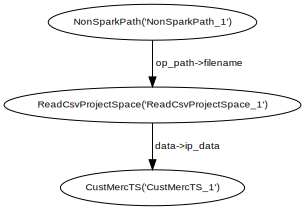

In [12]:
pipe

In [14]:
pipe.execute()

log path: /tmp/tmpktg72aix/temp


{}

In [14]:
import sys

In [15]:
sys.modules['razor.project']

<module 'project' (namespace)>